In [276]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
import seaborn as sns
import glob
import scipy.stats as sc

In [277]:
# Read in Metadata
basefolder = ""
datafolder = ""
plotsfolder = 'plots'
namesfile = "all_sample_metadata.csv"
metadata = pd.read_csv(os.path.join(basefolder, namesfile))
# exclude samples with unknown age
metadata_age = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata_gDNA = metadata[metadata['gDNA']==1]

all_gca_tcrs = pd.read_csv(os.path.join(basefolder,'TCRs_for_clustering/all_GCA_tcrs_clean_nodup.csv'))

tcrs_to_analyze_clusters = pd.read_csv(os.path.join(basefolder,'resulting_tcrs', 'clustering1and3_top1000_highandmedconf_clusters.csv'))
tcrs_to_analyze_clusters['Subject_ID'] = tcrs_to_analyze_clusters['Name'].apply(lambda x: int(x.split('-')[0]))

tcrs_to_analyze = pd.read_csv(os.path.join(basefolder,'resulting_TCRs/', 'clustering1and3_top1000_highandmedconf.csv'))
tcrs_to_analyze['Subject_ID'] = tcrs_to_analyze['Name'].apply(lambda x: int(x.split('-')[0]))

In [278]:
# read in clinical data (subset)
clinical_data = pd.read_excel(os.path.join(basefolder,'clinical_histo_data', 'Final clinical data 15052023.xlsx'))
clinical_data2 = pd.read_csv(os.path.join(basefolder,'clinical_histo_data', 'relevant_clinical_data_clean_extended.csv'))
# read in clinical data (subset)
clinical_data_b = pd.read_csv(os.path.join(basefolder,'clinical_histo_data', 'final_clinical_data_binarized.csv'))
for column in ['N15_dBiopsyposnegpnly']:
    clinical_data_b[column] = clinical_data_b[column].fillna(0)
def rename(x):
    if x == 0:
        return 'clinical diag'
    elif x == 1:
        return 'pos biopsy'
def get_steroid_days(id):
    row = clinical_data2[clinical_data2['Database ID '] == id]
    if len(row) != 1:
        days = np.nan
    else:
        days = row['Days on steroids at TAB'].values[0]
    return days
def get_symptom_days(id):
    row = clinical_data2[clinical_data2['Database ID '] == id]
    if len(row) != 1:
        days = np.nan
    else:
        days = row['symptomtosteroidsclean'].values[0]
    return days

clinical_data_b['Visual Disturbance'] = clinical_data_b['VisualSummary'].apply(lambda x: 1 if x>=1 else 0)
clinical_data_b['Steroids_to_TAB'] = clinical_data_b['Database ID'].apply(lambda x: get_steroid_days(x))
clinical_data_b['Symptom_to_Steroid'] = clinical_data_b['Database ID'].apply(lambda x: get_symptom_days(x))
clinical_data_b['Symptom_to_TAB'] = clinical_data_b['Symptom_to_Steroid']+clinical_data_b['Steroids_to_TAB']
def sum_columns(df, columns):
    other_columns = [x for x in df.columns if x not in columns]
    df2 = df.drop(other_columns, axis=1)
    sum = df2.sum(axis=1, skipna=True, numeric_only=True)
    return sum

In [279]:
# Days of disease

day_to_disease = pd.read_csv(os.path.join(basefolder, 'clinical_histo_data', 'Diagnosis to sample_GCA cases 31032023.csv'))
day_to_disease

def get_time(id, type):
    if id in set(day_to_disease['Database ID']):
        if type == 'DNA':
            time = day_to_disease[day_to_disease['Database ID'] == id]['Time from diagnosis to DNA sample (months)'].values[0]
        elif type == 'FFPE':
            time = day_to_disease[day_to_disease['Database ID'] == id]['Time from diagnosis to biopsy (FFPE) (months)'].values[0]
    else:
        time = np.nan
    return time

clinical_data_b['diag_to_dna'] = clinical_data_b['Database ID'].apply(lambda x: get_time(x, 'DNA'))
clinical_data_b['diag_to_biopsy'] = clinical_data_b['Database ID'].apply(lambda x: get_time(x, 'FFPE'))

In [280]:
# Per Severity Score, check number, average expansion, common clusters of relevant clones in patients
def get_dicts(score):
    nrs_dict = {}
    expansions_frac_dict = {}
    expansions_count_dict = {}
    total_expansions_frac_dict = {}
    for value in set(clinical_data_b[score].dropna()):
        nrs = []
        expansions_frac = []
        expansions_count = []
        total_expansions_frac = []

        subset_patients = clinical_data_b[clinical_data_b[score] == value]['Database ID']
        for subject in subset_patients:
            subset_tcrs = tcrs_to_analyze[tcrs_to_analyze['Subject_ID'] == subject]

            nr_tcrs = len(subset_tcrs)
            avg_expansion_frac = np.median(subset_tcrs['cloneFraction'])
            avg_expansion_count = np.median(subset_tcrs['cloneCount'])
            total_expansion_frac = np.sum(subset_tcrs['cloneFraction'])

            nrs.append(nr_tcrs)
            expansions_frac.append(avg_expansion_frac)
            expansions_count.append(avg_expansion_count)
            total_expansions_frac.append(total_expansion_frac)

        nrs_dict[value] = nrs
        expansions_frac_dict[value] = expansions_frac
        expansions_count_dict[value] = expansions_count
        total_expansions_frac_dict[value] = total_expansions_frac
    return nrs_dict, expansions_count_dict, expansions_frac_dict, total_expansions_frac_dict

(0.14486508188098976, 0.23149033348189285)
0.14294381615504123 0.23780401358962644


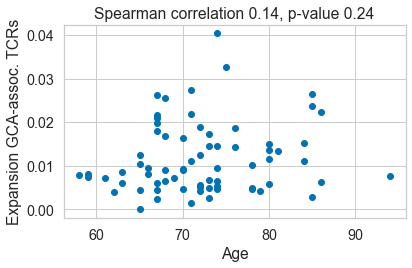

In [281]:
# Per Severity Score, check number, average expansion, common clusters of relevant clones in patients
def get_corr(data, score, basefile):
    total_expansions_frac = []
    scores = []
    clinical_data_b_dropna = data.dropna(subset=[score])
    for subject in clinical_data_b_dropna['Database ID']:
        subset_tcrs = basefile[basefile['Subject_ID'] == subject]
        total_expansion_frac = np.sum(subset_tcrs['cloneFraction'])
        total_expansions_frac.append(total_expansion_frac)
        scores.append(clinical_data_b_dropna[clinical_data_b_dropna['Database ID'] == subject][score].values[0])
    return total_expansions_frac, scores

sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.3)
total_expansions_frac, scores = get_corr(clinical_data_b,'Age', tcrs_to_analyze)
print(stats.pearsonr(scores, total_expansions_frac))

corr, p = stats.spearmanr(scores, total_expansions_frac)
print(corr, p)
plt.title(f'Spearman correlation {corr:.2f}, p-value {p:.2f}')
plt.scatter(scores, total_expansions_frac)
plt.xlabel('Age')
plt.ylabel('Expansion GCA-assoc. TCRs')
plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, 'age_corr.pdf'))

−−−−−−−−−−Sex−−−−−−−−−−−−−
Ttest_indResult(statistic=0.40453406710559736, pvalue=0.6870534859279558)


/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


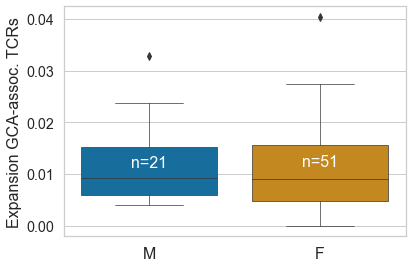

In [282]:
severity_scores = ['Sex']
for score in severity_scores:

    print('−−−−−−−−−−'+score+'−−−−−−−−−−−−−')
    nrs_dict, expansions_count_dict, expansions_frac_dict, total_expansions_frac_dict = get_dicts(score)
    fig, ax = plt.subplots(1, 1)

    labels, data = [*zip(*total_expansions_frac_dict.items())]
    splot3 = sns.boxplot(data=data, ax=ax, width=0.8, linewidth = 0.7)
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_ylabel('Expansion GCA-assoc. TCRs', fontsize=16)

    n_height = (np.quantile(data[0], 0.75)-np.median(data[0]))/2
    ax.text(0, np.median(data[0])+n_height, 'n='+str(len(data[0])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(data[1], 0.75)-np.median(data[1]))/2
    ax.text(1, np.median(data[1])+n_height, 'n='+str(len(data[1])), ha='center', va='center', fontsize=16, color='white')


    dist1 = np.array(total_expansions_frac_dict[labels[0]])
    dist1 = dist1[~np.isnan(dist1)]
    dist2 = np.array(total_expansions_frac_dict[labels[1]])
    dist2 = dist2[~np.isnan(dist2)]
    print(stats.ttest_ind(dist1,dist2))

    plt.tight_layout()

    plt.savefig(os.path.join(basefolder, plotsfolder, score+'.pdf'))
    plt.show()
    

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N15_dBiopsyposnegpnly 0.014281347378718884
PMRYESNO 0.21272826845289738


/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CICYN 0.9893756818526134


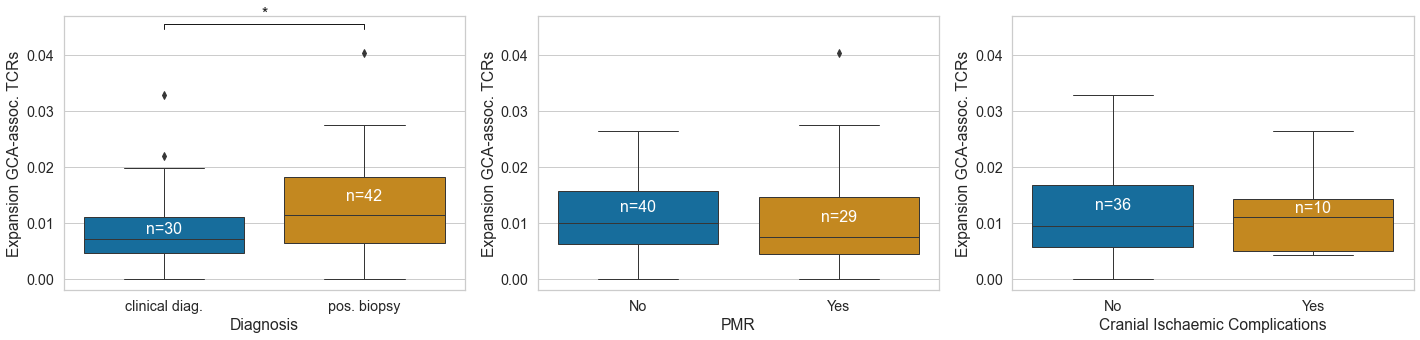

In [283]:
severity_scores = ['N15_dBiopsyposnegpnly', 'PMRYESNO', 'CICYN']

fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for i, score in enumerate(severity_scores):
    nrs_dict, expansions_count_dict, expansions_frac_dict, total_expansions_frac_dict = get_dicts(score)

    labels, data = [*zip(*total_expansions_frac_dict.items())]
    splot = sns.boxplot(data=data, ax=ax[i], width=0.8, linewidth = 1)
    
    if score == 'N15_dBiopsyposnegpnly':
        title = 'Diagnosis'
        plotlabels= ('clinical diag.', 'pos. biopsy')
    if score == 'PMRYESNO':
        title = 'PMR'
        plotlabels = ('No', 'Yes')
    if score == 'CICYN':
        title = 'Cranial Ischaemic Complications'
        plotlabels = ('No', 'Yes')
    ax[i].set_xlabel(title)
    ax[i].set_xticklabels(plotlabels)
    ax[i].set_ylabel('Expansion GCA-assoc. TCRs')
    
    dist1 = np.array(total_expansions_frac_dict[labels[0]])
    dist1 = dist1[~np.isnan(dist1)]
    dist2 = np.array(total_expansions_frac_dict[labels[1]])
    dist2 = dist2[~np.isnan(dist2)]
    U, p = stats.mannwhitneyu(dist1, dist2, alternative='two-sided')
    print(score, p)

    n_height = (np.quantile(data[0], 0.75)-np.median(data[0]))/2
    ax[i].text(0, np.median(data[0])+n_height, 'n='+str(len(data[0])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(data[1], 0.75)-np.median(data[1]))/2
    ax[i].text(1, np.median(data[1])+n_height, 'n='+str(len(data[1])), ha='center', va='center', fontsize=16, color='white')


    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[i].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[i].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[i].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)
    ax[i].set_yticks([0, 0.01, 0.02, 0.03, 0.04])
    ax[i].set_ylim(bottom=-0.002, top=0.047)

plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'relevant_clinical_ass.pdf'))


In [284]:
def get_cluster_ratios(ids,big_clusters):
    tcrs_subset = tcrs_to_analyze_clusters[tcrs_to_analyze_clusters['Subject_ID'].isin(ids)]
    sizes = [len(tcrs_subset[tcrs_subset['cluster'] == x])for x in big_clusters]
    return sizes

big_clusters = [1, 4, 7, 27, 3, 15, 18, 2, 19, 22]

In [285]:
# background distribution of relative cluster occurence 
def get_clusterplot(low_score, high_score):
    bin_labels = [2,15,4,19,22,7,27,18,3]
    bins = [x-0.5 for x in range(len(bin_labels)+1)]
    counts_low = []
    for subject in low_score:
        subset_tcrs = tcrs_to_analyze_clusters[tcrs_to_analyze['Subject_ID'] == subject]
        cluster_counts = Counter(subset_tcrs['cluster'])
        counts_low.append([cluster_counts[x] for x in bin_labels])
    counts_low_scaled = []
    for row in counts_low:
        counts_low_scaled.append([x/np.sum(row) for x in row])
    counts_low_scaled = np.array(counts_low_scaled)
    avg_counts_low = [np.nanmean(counts_low_scaled[:,x]) for x in range(len(bin_labels))]
    #avg_counts_low_scaled = [x/np.sum(avg_counts_low) for x in avg_counts_low]

    counts_high = []
    for subject in high_score:
        subset_tcrs = tcrs_to_analyze_clusters[tcrs_to_analyze['Subject_ID'] == subject]
        cluster_counts = Counter(subset_tcrs['cluster'])
        counts_high.append([cluster_counts[x] for x in bin_labels])
    counts_high_scaled = []
    for row in counts_high:
        counts_high_scaled.append([x/np.sum(row) for x in row])
    counts_high_scaled = np.array(counts_high_scaled)

    avg_counts_high = [np.nanmean(counts_high_scaled[:,x]) for x in range(len(bin_labels))]
    #avg_counts_high_scaled = [x/np.sum(avg_counts_high) for x in avg_counts_high]

    plt.stairs(avg_counts_high, bins, color='red')
    plt.stairs(avg_counts_low, bins, color='grey',fill=True, alpha=0.5)
    plt.xticks(ticks=[x+0.5 for x in bins[:-1]], labels=bin_labels)

    counts_high_scaled = pd.DataFrame(counts_high_scaled, columns=bin_labels)
    sns.stripplot(data=counts_high_scaled, jitter=0.3)
    plt.show()
    return

In [286]:
histo_raw = pd.read_csv(os.path.join(basefolder, 'clinical_histo_data', 'histo.csv'))
histo_raw

,Unnamed: 0,Database ID,Section number,GCA present?,Any granulomatous infiltrate?,Granulomatous infiltrate in adventitia?,Granulomatous infiltrate in media?,Granulomatous infiltrate in intima?,Amy lymphocytic infiltrate?,[label missing],...,Aggregates?,Infiltrate around vasa vasorum?,PALI?,Media destruction?,Neoangiogenesis?,Hyperplasia?,Fibrosis?,Oedema?,"Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete)",ID string
0,0,8546,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8546
1,1,8546,2,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8546
2,2,8546,3,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN,8546
3,3,11037,1,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,11037
4,4,11037,2,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,11037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,463,18091,2/1.,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,18091
546,464,18091,2/2.,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,18091
547,465,18091,2/3.,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,18091
548,466,18091,2/4.,1,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,18091


In [287]:
columns_list = ['Any granulomatous infiltrate?', 
       'Adventitia pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)',
       'Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)',
       'Intima pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)',
       'Giant cells? ', 'Aggregates?', 'Infiltrate around vasa vasorum?',
       'PALI?', 'Media destruction?', 'Neoangiogenesis?', 'Oedema?',
       'Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete)']

In [288]:
histo_max = []
for subject in set(histo_raw['Database ID']):
    subset = histo_raw[histo_raw['Database ID'] == subject]
    maxs = [int(subject)]
    for column in columns_list:
        mean = np.mean(subset[column].dropna())
        max = np.max(subset[column].dropna())
        maxs.append(max)
    histo_max.append(maxs)
    

In [289]:
columns_list.insert(0,'Database ID')
histo_max = pd.DataFrame(histo_max, columns=columns_list)

In [290]:
relevant_histo_max = histo_max[histo_max['Database ID'].isin(clinical_data_b['Database ID'])] 
relevant_histo_max.dropna(subset=['Any granulomatous infiltrate?', 
       'Adventitia pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)',
       'Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)'], inplace=True)

for score in columns_list[1:]:
    if len(set(relevant_histo_max[score])) > 2:
        maxi = np.max(relevant_histo_max[score])
        print(maxi)
        relevant_histo_max[score] = ['low' if x < maxi/2 else 'high' for x in relevant_histo_max[score]]

clinical_only = set(clinical_data_b[clinical_data_b['N15_dBiopsyposnegpnly'] == 'clinical diag']['Database ID'])
pos_bio = set(clinical_data_b[clinical_data_b['N15_dBiopsyposnegpnly'] == 'pos biopsy']['Database ID'])

3.0
3.0
4.0


/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [291]:
relevant_cols = [
    'Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse)',
    'Giant cells? ',
    'Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete)',
 ]
relevant_col_names = [
    'Media Inflammation',
    'Giant cells',
    'Occlusion grade'
]

Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse) 0.00131218895520955
Giant cells?  0.03125223885693879
Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete) 0.5938461538461539


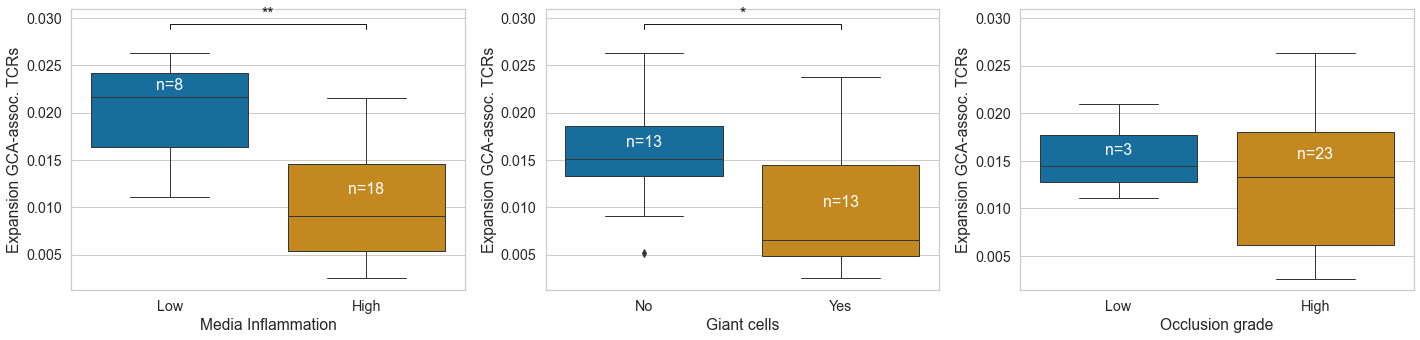

In [292]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(relevant_cols):

    total_expansions_frac, scores = get_corr(relevant_histo_max, score, tcrs_to_analyze)
    
    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        elif x == 0:
            low_ids.append(i)
        elif x == 2:
            low_ids.append(i)
    
    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data['Low'] = np.array(total_expansions_frac)[low_ids]
    plot_data['High'] = np.array(total_expansions_frac)[high_ids]

    labels, data = [*zip(*plot_data.items())] 

    if score == 'Giant cells? ':
        labels = ('No', 'Yes')
    
    splot = sns.boxplot(data=data, ax=ax[j], width=0.8, linewidth =1)
    ax[j].set_xticklabels(labels)
    ax[j].set_ylabel('Expansion GCA-assoc. TCRs')
    ax[j].set_xlabel(relevant_col_names[j])

    n_height = (np.quantile(plot_data['Low'], 0.75)-np.median(plot_data['Low']))/2
    ax[j].text(0, np.median(plot_data['Low'])+n_height, 'n='+str(len(plot_data['Low'])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(plot_data['High'], 0.75)-np.median(plot_data['High']))/2
    ax[j].text(1, np.median(plot_data['High'])+n_height, 'n='+str(len(plot_data['High'])), ha='center', va='center', fontsize=16, color='white')


    U, p = stats.mannwhitneyu(plot_data['High'], plot_data['Low'], alternative='two-sided')
    print(score, p)

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)
    ax[j].set_yticks([0.005, 0.01, 0.015, 0.02, 0.025, 0.03])
    ax[j].set_ylim(top=0.031)
plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'relevant_hist_ass.pdf'))


8 18
Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse) 0.6339709260735091
13 13
Giant cells?  0.7761081290213634
3 23
Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete) 1.0


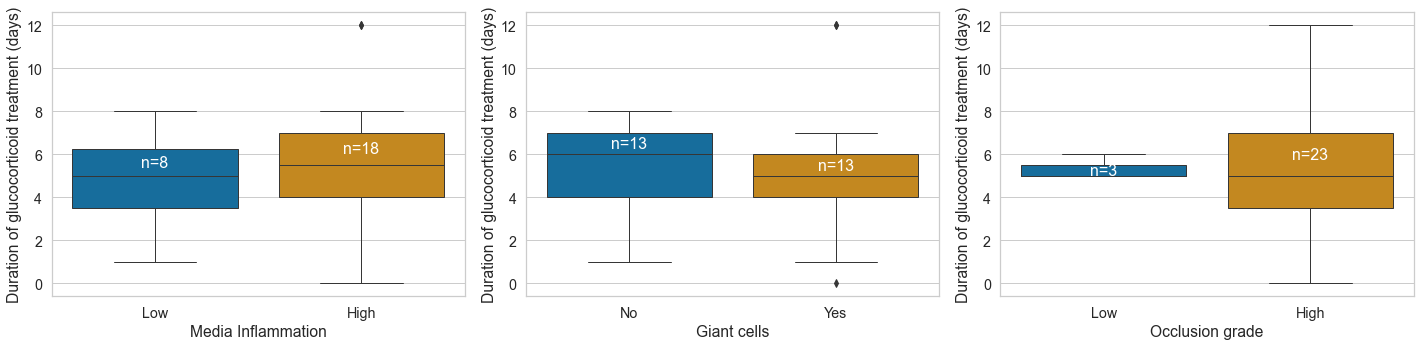

In [293]:
def get_corr_clinical(data, score, basefile):
    diag_to_biopsys = []
    Steroids_to_TABs = []
    scores = []
    clinical_data_b_dropna = data.dropna(subset=[score])
    for subject in clinical_data_b_dropna['Database ID']:
        subset_patient = basefile[basefile['Database ID'] == subject]
        diag_to_biopsy = subset_patient['Symptom_to_TAB'].values[0]
        diag_to_biopsys.append(diag_to_biopsy)
        Steroids_to_TAB = subset_patient['Steroids_to_TAB'].values[0]
        Steroids_to_TABs.append(Steroids_to_TAB)
        scores.append(clinical_data_b_dropna[clinical_data_b_dropna['Database ID'] == subject][score].values[0])
    return diag_to_biopsys, Steroids_to_TABs, scores

fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(relevant_cols):

    diag_to_biopsys, Steroids_to_TABs, scores = get_corr_clinical(relevant_histo_max, score, clinical_data_b)
    
    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        elif x == 0:
            low_ids.append(i)
        elif x == 2:
            low_ids.append(i)
    
    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data['Low'] = np.array(Steroids_to_TABs)[low_ids]
    plot_data['High'] = np.array(Steroids_to_TABs)[high_ids]
    print(len(plot_data['Low']), len(plot_data['High']))
    labels, data = [*zip(*plot_data.items())] 
    #sns.boxenplot(data=data)
    #plt.boxplot(data, showmeans=True)
    if score == 'Giant cells? ':
        labels = ('No', 'Yes')
    splot = sns.boxplot(data=data, ax=ax[j], width=0.8, linewidth = 1)
    ax[j].set_xticklabels(labels)
    ax[j].set_ylabel('Duration of glucocorticoid treatment (days)')
    ax[j].set_xlabel(relevant_col_names[j])

    n_height = (np.quantile(plot_data['Low'], 0.75)-np.median(plot_data['Low']))/2
    ax[j].text(0, np.median(plot_data['Low'])+n_height, 'n='+str(len(plot_data['Low'])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(plot_data['High'], 0.75)-np.median(plot_data['High']))/2
    ax[j].text(1, np.median(plot_data['High'])+n_height, 'n='+str(len(plot_data['High'])), ha='center', va='center', fontsize=16, color='white')


    U, p = stats.mannwhitneyu(plot_data['High'], plot_data['Low'], alternative='two-sided')
    print(score, p)

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'histo_vs_steroid.pdf'))


In [294]:
# Correlation with Diversity?
def diversity_measures(frequency, counts):
    # Species Richness
    total_species = len(frequency)
    
    # Shannon diversity
    i=0
    log_frequency = []
    while i < len(frequency):
        a = np.log(frequency[i])
        i+=1
        log_frequency.append(a)
    H1 = -np.sum(frequency * log_frequency)

    # Simpson diversity index
    N = np.sum(frequency)
    n = frequency 
    squared_frequency=[]
    i=0
    while i < len(frequency):
        a = frequency[i]**2
        i+=1
        squared_frequency.append(a)
    simpson = sum(squared_frequency)

    # Berger-Park Index
    B = np.max(frequency)

    #Chao2 estimator
    f1 = 0
    f2 = 0
    for count in counts:
        if int(count) == 1:
            f1 += 1
        if int(count) == 2:
            f2 += 1
    Chao2_bias = total_species + f1*(f1-1)/(2*(f2+1))

    return total_species, H1, (1-simpson), B, Chao2_bias

In [295]:
## Cohort 1
# Read in Names of Files here
metadata = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata['Age'] = [int(age) for age in metadata['Age']]
# exclude samples with unknown age
metadata_gDNA = metadata[metadata['gDNA']==1]

In [296]:
# GCA DATA
diversities = []
for name in metadata[metadata['gDNA'] == 0]['ID']:
    if len(glob.glob(basefolder+'/cleaned data FFPE/*'+name+'*_cleaned_2.txt')) > 1: #check samples are unique
        print(name, glob.glob(basefolder+'/cleaned data/*'+name+'*_cleaned_2.txt'))
    for filename in glob.glob(basefolder+'/cleaned data FFPE/*'+name+'*_cleaned_2.txt'):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        total_species, H1, simpson, B, Chao2_bias = diversity_measures(sample['cloneFraction'], sample['cloneCount'])
        diversities.append([total_species, H1, simpson, B])
diversities = pd.DataFrame(diversities, columns = ['Species R.', 'Shannon', 'Simpson', 'Berger-Park'])
gca_data = pd.concat([metadata[metadata['gDNA'] == 0].reset_index(), diversities], axis=1)

In [297]:
gca_data['ID'] = gca_data['ID'].apply(lambda x: int(x))

Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse) 0.8909932568105469
10.0 18.75 25.25
Giant cells?  0.26041793305195615
9.0 13.5 18.0
Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete) 0.26932691061811265
24.0 19.0 35.0


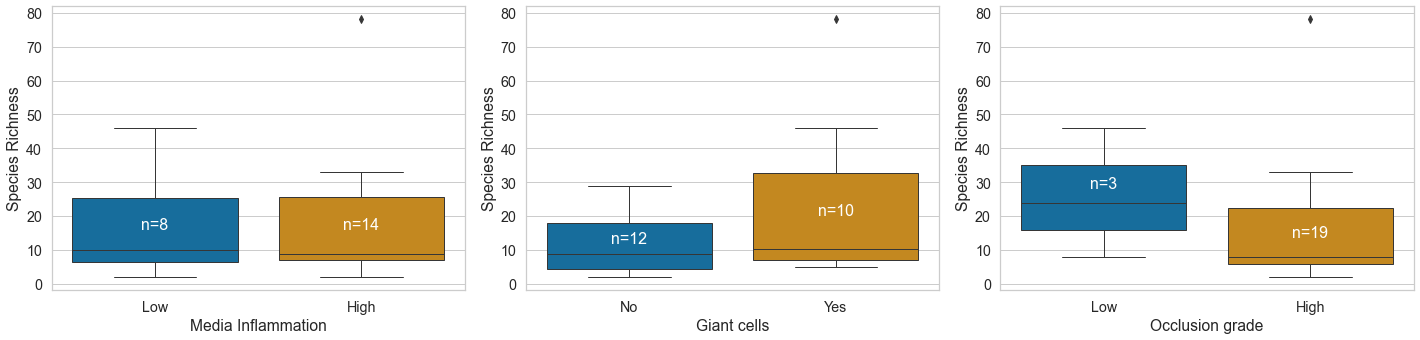

In [298]:

def get_diversity_corr(gca_data, score, div, clinical_data):
    scores = []
    diversities = []
    clinical_data_b_dropna = clinical_data.dropna(subset=[score])
    for subject in clinical_data_b_dropna['Database ID']:
        subset_diversity = gca_data[gca_data['ID'] == subject]
        
        if len(subset_diversity) != 0:
            diversities.append(subset_diversity[div].values[0])
            scores.append(clinical_data_b_dropna[clinical_data_b_dropna['Database ID'] == subject][score].values[0])
    return diversities, scores


fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(relevant_cols):    
    
    diversities, scores = get_diversity_corr(gca_data, score, 'Species R.', relevant_histo_max)

    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        elif x == 0:
            low_ids.append(i)
        elif x == 2:
            low_ids.append(i)
    
    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data['Low'] = np.array(diversities)[low_ids]
    plot_data['High'] = np.array(diversities)[high_ids]

    labels, data = [*zip(*plot_data.items())] 

    if score == 'Giant cells? ':
        labels = ('No', 'Yes')
    splot = sns.boxplot(data=data, ax=ax[j], width=0.8, linewidth = 1)
    ax[j].set_xticklabels(labels)
    ax[j].set_ylabel('Species Richness')
    ax[j].set_xlabel(relevant_col_names[j])

    U, p = stats.mannwhitneyu(plot_data['High'], plot_data['Low'], alternative='two-sided')
    print(score, p)

    n_height = (np.quantile(plot_data['Low'], 0.75)-np.median(plot_data['Low']))/2
    ax[j].text(0, np.median(plot_data['Low'])+n_height, 'n='+str(len(plot_data['Low'])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(plot_data['High'], 0.75)-np.median(plot_data['High']))/2
    ax[j].text(1, np.median(plot_data['High'])+n_height, 'n='+str(len(plot_data['High'])), ha='center', va='center', fontsize=16, color='white')

    print(np.median(plot_data['Low']), sc.iqr(plot_data['Low']), np.quantile(plot_data['Low'], 0.75))

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'richness_histo.pdf'))



Media pattern (0: normal, 1: focal, 2: multifocal, 3: diffuse) 0.9203364918535197
1.0146366033278431 1.02411134862788 1.8113293347085757
Giant cells?  0.09268132325230818
0.9783456148503682 0.8003172528118363 1.3134908656164943
Occlusion grade (0: none, 1: <50%, 2: 50-75%, 3: 75-100%, 4: complete) 0.225974025974026
1.7823532390070882 0.6936539590388042 2.1202887505892924


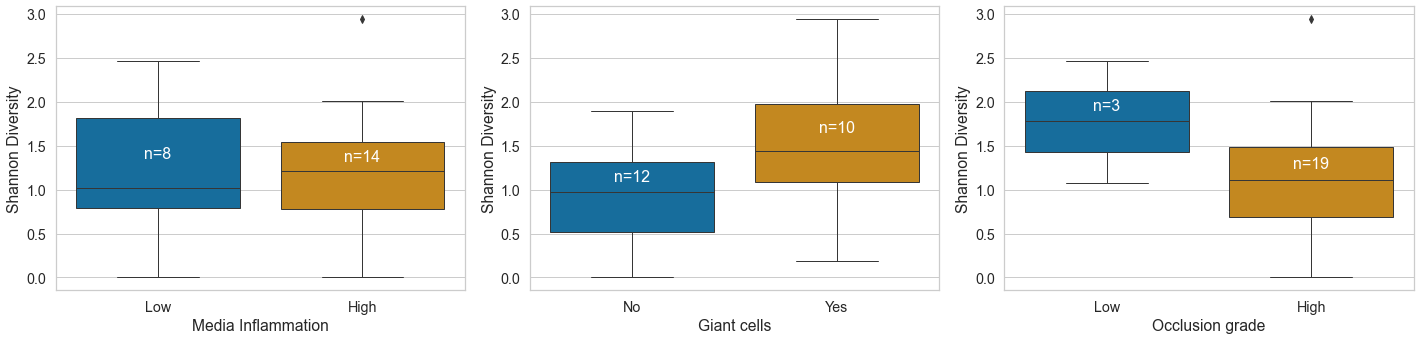

In [299]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(relevant_cols):    
    
    diversities, scores = get_diversity_corr(gca_data, score, 'Shannon', relevant_histo_max)

    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        elif x == 0:
            low_ids.append(i)
        elif x == 2:
            low_ids.append(i)
    
    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data['Low'] = np.array(diversities)[low_ids]
    plot_data['High'] = np.array(diversities)[high_ids]

    labels, data = [*zip(*plot_data.items())] 
    if score == 'Giant cells? ':
        labels = ('No', 'Yes')
    
    splot = sns.boxplot(data=data, ax=ax[j], width=0.8, linewidth = 1)
    ax[j].set_xticklabels(labels)
    ax[j].set_ylabel('Shannon Diversity')
    ax[j].set_xlabel(relevant_col_names[j])

    U, p = stats.mannwhitneyu(plot_data['High'], plot_data['Low'], alternative='two-sided')
    print(score, p)

    n_height = (np.quantile(plot_data['Low'], 0.75)-np.median(plot_data['Low']))/2
    ax[j].text(0, np.median(plot_data['Low'])+n_height, 'n='+str(len(plot_data['Low'])), ha='center', va='center', fontsize=16, color='white')
    n_height = (np.quantile(plot_data['High'], 0.75)-np.median(plot_data['High']))/2
    ax[j].text(1, np.median(plot_data['High'])+n_height, 'n='+str(len(plot_data['High'])), ha='center', va='center', fontsize=16, color='white')

    print(np.median(plot_data['Low']), sc.iqr(plot_data['Low']), np.quantile(plot_data['Low'], 0.75))

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(basefolder, plotsfolder, 'shannon_histo.pdf'))



Species R. 0.015378919027945127
Shannon 0.03300492610837438
Berger-Park 0.026108374384236452


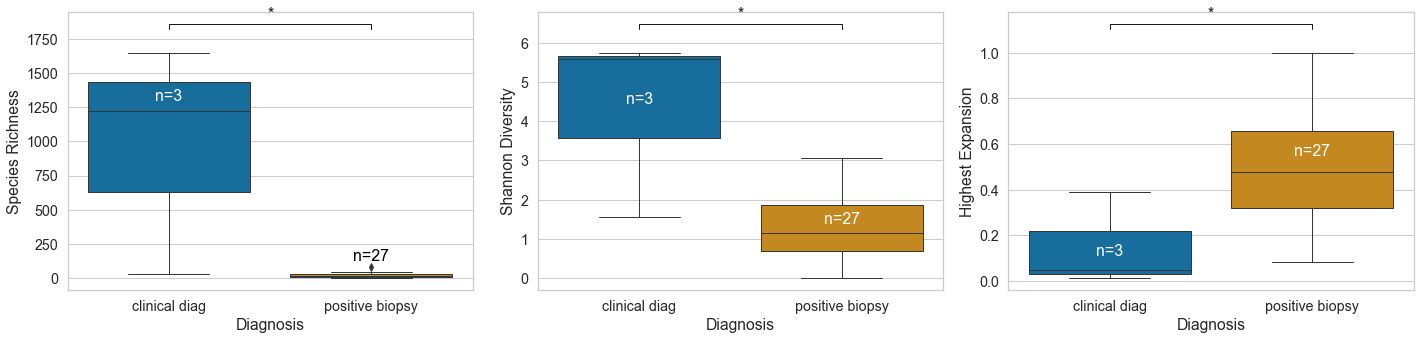

In [300]:
severity_scores = ['N15_dBiopsyposnegpnly']
diversitiy_scores = ['Species R.','Shannon','Berger-Park']
diversity_labels = ['Species Richness', 'Shannon Diversity', 'Highest Expansion']
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(diversitiy_scores):    
    
    diversities, scores = get_diversity_corr(gca_data, 'N15_dBiopsyposnegpnly', score,  clinical_data_b)

    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        if x == 0:
            low_ids.append(i)
        if x == 2:
            low_ids.append(i)
        if x == 'clinical diag':
            low_ids.append(i)
            
    low_label = 'clinical diag'
    high_label= 'positive biopsy'
    
    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data[low_label] = np.array(diversities)[low_ids]
    plot_data[high_label] = np.array(diversities)[high_ids]

    labels, data = [*zip(*plot_data.items())] 

    splot = sns.boxplot(data=data, ax=ax[j], width=0.8, linewidth = 1)
    ax[j].set_xticklabels(labels)
    ax[j].set_ylabel(diversity_labels[j])
    ax[j].set_xlabel('Diagnosis')

    if score == 'Species R.':
        n_height = (np.quantile(plot_data[low_label], 0.75)-np.median(plot_data[low_label]))/2
        ax[j].text(0, np.median(plot_data[low_label])+n_height, 'n='+str(len(plot_data[low_label])), ha='center', va='center', fontsize=16, color='white')
        n_height = (np.quantile(plot_data[high_label], 0.75)-np.median(plot_data[high_label]))/2
        ax[j].text(1, np.median(plot_data[high_label])+150, 'n='+str(len(plot_data[high_label])), ha='center', va='center', fontsize=16, color='black')
    elif score == 'Shannon':
        n_height = (np.median(plot_data[low_label])-np.quantile(plot_data[low_label], 0.25))/2
        ax[j].text(0, np.median(plot_data[low_label])-n_height, 'n='+str(len(plot_data[low_label])), ha='center', va='center', fontsize=16, color='white')
        n_height = (np.quantile(plot_data[high_label], 0.75)-np.median(plot_data[high_label]))/2
        ax[j].text(1, np.median(plot_data[high_label])+n_height, 'n='+str(len(plot_data[high_label])), ha='center', va='center', fontsize=16, color='white')
    else:
        n_height = (np.quantile(plot_data[low_label], 0.75)-np.median(plot_data[low_label]))/2
        ax[j].text(0, np.median(plot_data[low_label])+n_height, 'n='+str(len(plot_data[low_label])), ha='center', va='center', fontsize=16, color='white')
        n_height = (np.quantile(plot_data[high_label], 0.75)-np.median(plot_data[high_label]))/2
        ax[j].text(1, np.median(plot_data[high_label])+n_height, 'n='+str(len(plot_data[high_label])), ha='center', va='center', fontsize=16, color='white')

    U, p = stats.mannwhitneyu(plot_data[high_label], plot_data[low_label], alternative='two-sided')
    print(score, p)

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(basefolder, plotsfolder, 'diversity_clinical.pdf'))



N15_dBiopsyposnegpnly clinical diag 3
N15_dBiopsyposnegpnly positive biopsy 27
N15_dBiopsyposnegpnly 0.015378919027945127
PMRYESNO Low 21
PMRYESNO High 9
PMRYESNO 0.09352367232889226
CICYN Low 17
CICYN High 5
CICYN 0.7238964072255258


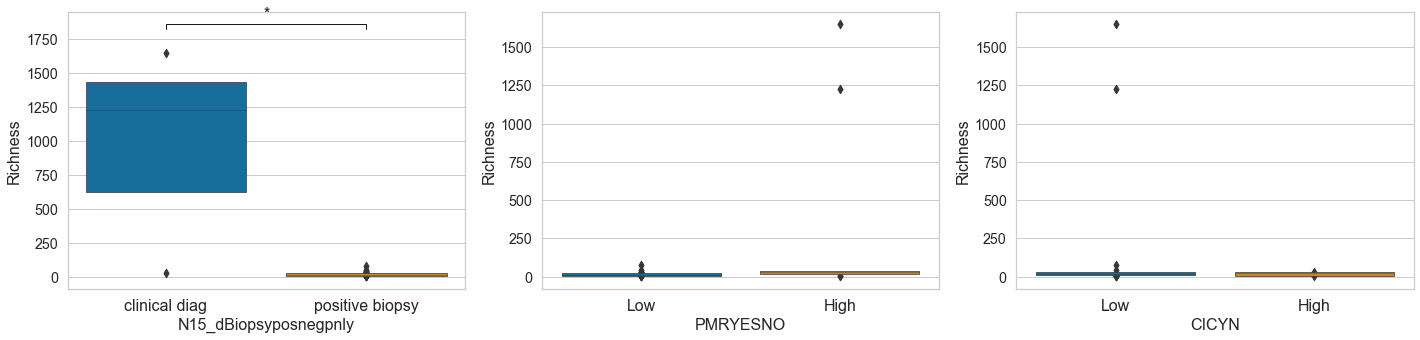

In [301]:
severity_scores = ['N15_dBiopsyposnegpnly', 'PMRYESNO', 'CICYN']

fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5))
for j, score in enumerate(severity_scores):    
    
    diversities, scores = get_diversity_corr(gca_data, score, 'Species R.', clinical_data_b)

    low_ids = []
    for i,x in enumerate(scores):
        if x == 'low':
            low_ids.append(i)
        if x == 0:
            low_ids.append(i)
        if x == 2:
            low_ids.append(i)
        if x == 'clinical diag':
            low_ids.append(i)
            
    if score == 'N15_dBiopsyposnegpnly':
        low_label = 'clinical diag'
        high_label= 'positive biopsy'
    else:
        low_label = 'Low'
        high_label= 'High'

    high_ids = [x for x in range(len(scores)) if x not in low_ids]
    plot_data = {}
    plot_data[low_label] = np.array(diversities)[low_ids]
    plot_data[high_label] = np.array(diversities)[high_ids]

    labels, data = [*zip(*plot_data.items())] 
    #sns.boxenplot(data=data)
    #plt.boxplot(data, showmeans=True)
    for label in plot_data.keys():
        print(score, label, len(plot_data[label]))
    splot = sns.boxenplot(data=data, ax=ax[j], width=0.8, linewidth = 0.7)
    ax[j].set_xticklabels(labels, fontsize=16)
    ax[j].set_ylabel('Richness', fontsize=16)
    ax[j].set_xlabel(severity_scores[j], fontsize=16)

    U, p = stats.mannwhitneyu(plot_data[high_label], plot_data[low_label], alternative='two-sided')
    print(score, p)

    # Significance bars
    if p <= 0.05:
        # Columns corresponding to the datasets of interest
        x1 = 0
        x2 = 1
        # What level is this bar among the bars above the plot?
        level = 1
        # Plot the bar
        bottom, top = ax[j].get_ylim()
        y_range = top - bottom
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax[j].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=16)

plt.tight_layout()

#plt.savefig(os.path.join(basefolder, plotsfolder, 'berger-park_clinical.pdf'))



In [302]:
clinical_data_b.to_csv(os.path.join(basefolder,'clinical_summary.csv'))